In [ ]:
"""
Max Bongers
30-6-2023
MRI and Monte Carlo Model for master thesis "Optimizing b-value Composition For Maximizing ADC Contrast between Cancerous and Healthy Breast Tissue using a Diffusion Weighted MRI Simulator"
This file can be used to test restricted diffusion inside a circle
"""

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from celluloid import Camera
import planar
from scipy.spatial.transform import Rotation
import copy
import pandas as pd
import cv2
import matplotlib.animation as animation
from math import sin, cos
import multiprocessing
from multiprocessing import Queue
from numba import jit, cuda
import numba as numba
import time
import os

def check_cell(x,y, cells):
    for cell in cells:
        if cell.contains_point((x,y)):
            return cell
    return False

def check_incell_xy(x,y,x1,y1, cell):
    orX = x
    orY = y
    wallcheck = None
    if cell.contains_point((x1,y1)):
        return (x1, y1)
    
    count = 0
    
    while not cell.contains_point((x1,y1)):
        #plt.plot([x,x1],[y,y1])
        lineA = np.array([[x,y],[x1,y1]])
        cellist = cell
        for wall in range(len(cellist)-1):
            lineB = np.array([cellist[wall],cellist[wall+1]])
            a = nb_get_line_intersect(lineA, lineB)
            if a[0] != 0. or a[1] != 0.:
                if wallcheck != wall:
                    angle = (ang(lineA,lineB) * 2)#(ang(lineA,lineB) * 2)
                    rotXD = rotateP([lineA[1][0],lineA[1][1]],math.radians(angle),a)
                    x1 = rotXD[0]
                    y1 = rotXD[1]
                    x = a[0]
                    y = a[1]
                    wallcheck = wall
                    #print("XD")
                    """
                    xs, ys = zip(*cell) 
                    plt.plot(xs,ys, color="black")
                    plt.plot([lineB[0][0],lineB[1][0]],[lineB[0][1],lineB[1][1]])
                    plt.plot([a[0],rotXD[0]],[a[1],rotXD[1]])
                    plt.show()
                    """
                    break

    return (rotXD[0], rotXD[1])

def check_outcell_xy(x,y,x1,y1, walls, wallmids, latest_walls, j):
    orX = x
    orY = y
    rotXD = [x1,y1]
    wallcheck = np.array([[2, 2], [2, 2]])

    if j % 10 == 0:
        max_distance = 0.01
        p = np.array([x,y])
        distances = np.linalg.norm(p - wallmids, axis=1)
        colliding_wall_segment_indices = np.where(distances < max_distance)[0] 
        nearby_walls = walls[colliding_wall_segment_indices]
    else:
        nearby_walls = latest_walls

    #print(len(nearby_walls))
    while(nearby_walls.size > 0):
        short = 1237896
        intersect = False
        lineA = np.array([[x,y],[x1,y1]])
        for wall in nearby_walls:
            if not np.array_equal(wall, wallcheck):
                lineB = np.array([wall[0],wall[1]])
                a = nb_get_line_intersect(lineA, lineB)
                if a[0] != 0. or a[1] != 0.:
                    intersect = True
                    new = math.dist(a, [x,y])
                    if new < short:
                        short = new
                        shortwall = wall
        
        if intersect == True:
            lineB = np.array([shortwall[0],shortwall[1]])
            a = nb_get_line_intersect(lineA, lineB)
            angle = 360 - (ang(lineA,lineB) * 2)
            rotXD = rotateP([lineA[1][0],lineA[1][1]],math.radians(angle),a)
            #plt.plot([x,x1],[y,y1])
            x1 = rotXD[0]
            y1 = rotXD[1]
            x = a[0]
            y = a[1]
            wallcheck = shortwall
            """
            for AA in nearby_walls:
                plt.plot([AA[0][0],AA[1][0]],[AA[0][1],AA[1][1]], color="black")

            plotty = lineB
            plt.plot([plotty[0][0],plotty[1][0]],[plotty[0][1],plotty[1][1]])
            plt.plot([a[0],rotXD[0]],[a[1],rotXD[1]], color="red")
            plt.show()
            """
        else:
            latest_walls = nearby_walls
            return (rotXD[0] - orX, rotXD[1] - orY, latest_walls)
    latest_walls = nearby_walls
    return (x1-orX, y1-orY, latest_walls)
        
def plotz(x,y,particle=0):
    fig, ax = plt.subplots()
    line, = ax.plot(x[particle], y[particle], color='blue')


    def update(num, x, y, line):
        line.set_data(x[:num+1], y[:num+1])
        #line.axes.axis([0, 100, 0, 100])
        return line,


    for i in polys:
        xs, ys = zip(*i) 
        plt.plot(xs,ys, color="black")

    ani = animation.FuncAnimation(fig, update, len(x[0]), fargs=[x[particle], y[particle], line],
                                  interval=100, blit=True)


    ani.save('test.gif')
    plt.show()
    
def multiT(arg, count):
    start = time.time()
    processes = []
    magnet = []
    positions = []
    qT = Queue()
    qP = 2#Queue()
    arg.append(qT)
    arg.append(qP)
    start = time.time()
    
    for i in range(count):#len(os.sched_getaffinity(0))
        p = multiprocessing.Process(target=simulate, args=(arg))
        processes.append(p)
        p.start()

    for p in processes:
        ret = qT.get() # will block
        magnet.append(ret)
        #ret1 = qP.get() # will block
        #positions.append(ret1)
        
    for p in processes:
        p.join()
        
    end = time.time()
    print("Duration    ", end-start)    
    return get_trans(magnet), _#positionXYZ(positions)

def positionXYZ(positions):
    x = []
    y = []
    z = []
    for i in range(len(positions)):
        for j in positions[i][0]:
            x.append(j)
        for j in positions[i][1]:
            y.append(j)
        for j in positions[i][2]:
            z.append(j)
    return (x,y,z)

def get_trans(magnet):
    trans = []
    long = []
    for j in range(steps):
        transX = 0
        transY = 0
        longZ = 0
        for i in magnet:
            transX += i[j][0]
            transY += i[j][1]
            longZ += i[j][2]
        trans.append(np.linalg.norm([transX,transY]))
        long.append(np.linalg.norm([longZ]))
    return trans, long

TWO_PI = 2 * math.pi

def is_convex_polygon(polygon):
    try:  # needed for any bad points or direction changes
        # Check for too few points
        if len(polygon) < 3:
            return False
        # Get starting information
        old_x, old_y = polygon[-2]
        new_x, new_y = polygon[-1]
        new_direction = math.atan2(new_y - old_y, new_x - old_x)
        angle_sum = 0.0
        # Check each point (the side ending there, its angle) and accum. angles
        for ndx, newpoint in enumerate(polygon):
            # Update point coordinates and side directions, check side length
            old_x, old_y, old_direction = new_x, new_y, new_direction
            new_x, new_y = newpoint
            new_direction = math.atan2(new_y - old_y, new_x - old_x)
            if old_x == new_x and old_y == new_y:
                return False  # repeated consecutive points

            # Calculate & check the normalized direction-change angle
            angle = new_direction - old_direction

            if angle <= -math.pi:
                angle += TWO_PI  # make it in half-open interval (-Pi, Pi]
            elif angle > math.pi:
                angle -= TWO_PI

            if ndx == 0:  # if first time through loop, initialize orientation
                if angle == 0.0:
                    return False
                orientation = 1.0 if angle > 0.0 else -1.0
            else:  # if other time through loop, check orientation is stable
                if orientation * angle <= 0.0:  # not both pos. or both neg.
                    return False
            # Accumulate the direction-change angle
            angle_sum += angle
        # Check that the total number of full turns is plus-or-minus 1
        return abs(round(angle_sum / TWO_PI)) == 1
    except (ArithmeticError, TypeError, ValueError):
        return False  # any exception means not a proper convex polygon

In [2]:
@numba.njit('float64[:,::1], float64[::1], float64', fastmath=True)
def nb_isBetween(line_ab, c, epsilon):
    """

    :param line_ab: like --> np.array([[731362.47087528, 9746708.78767337], [731297.282, 9746727.286]])
    :param c: point to check like --> np.array([731362.47087528, 9746708.78767337])
    :param epsilon:
    :return: check if points is on line or not netween point a and b
    """

    a, b = line_ab
    a_x, a_y = a
    b_x, b_y = b
    c_x, c_y = c

    crossproduct = (c_y - a_y) * (b_x - a_x) - (c_x - a_x) * (b_y - a_y)

    # compare versus epsilon for floating point values, or != 0 if using integers
    if abs(crossproduct) > epsilon:
        return False

    dotproduct = (c_x - a_x) * (b_x - a_x) + (c_y - a_y) * (b_y - a_y)
    if dotproduct < 0:
        return False

    squaredlengthba = (b_x - a_x) * (b_x - a_x) + (b_y - a_y) * (b_y - a_y)
    if dotproduct > squaredlengthba:
        return False

    return True

@numba.njit('float64[:,::1], float64[:,::1]', fastmath=True)
def nb_get_line_intersect(line_ab, line_cd):
    """

    :param line_ab: like --> np.array([[731362.47087528, 9746708.78767337], [731297.282, 9746727.286]])
    :param line_cd: like --> np.array([[731362.47087528, 9746708.78767337], [731297.282, 9746727.286]])
    :return: get point of intersection, if the points in on line ab or cd returns the point if not retunrs 0
    """
    A, B = line_ab
    C, D = line_cd

    # a1x + b1y = c1
    a1 = B[1] - A[1]
    b1 = A[0] - B[0]
    c1 = a1 * (A[0]) + b1 * (A[1])

    # a2x + b2y = c2
    a2 = D[1] - C[1]
    b2 = C[0] - D[0]
    c2 = a2 * (C[0]) + b2 * (C[1])

    # determinant
    det = a1 * b2 - a2 * b1

    # parallel line
    if det == 0:
        return np.array([0., 0.])

    # intersect point(x,y)
    x = ((b2 * c1) - (b1 * c2)) / det
    y = ((a1 * c2) - (a2 * c1)) / det

    #check if x and y area in the line segment interval
    if nb_isBetween(line_ab, np.array([x, y]), epsilon=0.001) and nb_isBetween(line_cd, np.array([x, y]), epsilon=0.001):
        return np.array([x, y])
    else:
        return np.array([0.,0.])
    
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]

def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = math.acos(dot_prod/magB/magA)
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360
    
    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else: 
        
        return ang_deg

def rotateP(xy, radians, origin=(0, 0)):
    x, y = xy
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = math.cos(radians)
    sin_rad = math.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y
    return qx, qy

In [3]:
# This function gets just one pair of coordinates based on the angle theta
def get_circle_coord(theta, x_center, y_center, radius):
    x = radius * math.cos(theta) + x_center
    y = radius * math.sin(theta) + y_center
    return (x,y)

# This function gets all the pairs of coordinates
def get_all_circle_coords(x_center, y_center, radius, n_points):
    thetas = [i/n_points * math.tau for i in range(n_points)]
    circle_coords = [get_circle_coord(theta, x_center, y_center, radius) for theta in thetas]
    return circle_coords

def create_circle(R):
    circle_coords = get_all_circle_coords(x_center = 0, 
                                          y_center = 0,
                                          radius = R,
                                          n_points = 10)


    polys = []
    cells = []

    circle_coords.append(circle_coords[0])
    circle_coords.reverse()
    polys.append(circle_coords)

    for i in polys:
        cells.append(planar.Polygon(i, is_convex=is_convex_polygon(i[:-1]), is_simple=True))

    walls =[]
    for poly in polys:
        for wall in range(len(poly)-1):
            walls.append([list(poly[wall]),list(poly[wall+1])])    

    wallmids = []
    for wall in walls:
        wallmids.append([(wall[0][0]+wall[1][0]) / 2,(wall[0][1]+wall[1][1]) / 2])
    wallmids = np.asarray(wallmids)
    walls = np.asarray(walls)
    return walls, polys, cells

In [9]:
def simulate(steps, step_size, b0, TR, T2, T1, starting_time, num_particles, gradient_str, gradient_duration, delta, R, magnetisationQ, positionsQ):
    axis = np.array([0.,0.,1.])
    axisYrot = []
    rotated = []
    rotated1 = []
    particle_spins_phase_angle = []
    particle_precession_frequencies = []
    magnetisation = []
    axisZrot = np.array([0.,0.,1.])
    axisZrots = []
    TE = delta + (gradient_duration) + starting_time
    pulse_180 = int(starting_time + gradient_duration + ((delta-gradient_duration)/2))
    x=[]
    y=[]
    z=[]
    latest_walls = []
    np.random.seed(random.randint(0,99999))
    gradient_str = gradient_str / 3
    for i in range(num_particles):
        rotated.append(i)
        rotated1.append(i)
        
        while(True):
            X1 = random.uniform(-R,R)
            Y1 = random.uniform(-R,R)
            inside = check_cell(X1,Y1, cells)
            if inside:
                break
                
        x.append(X1) #random.randint(1,99)
        y.append(Y1)
        z.append(random.random())
        alignment = -1 + (2 * random.random()**0.67)
        
        start_vec = np.array([0,0, 1])
        start_vec = start_vec / np.linalg.norm(start_vec)
        particle_spins_phase_angle.append(start_vec)

        b0_1 = np.random.normal(b0, 0) # 1e-07    # 0.5 partspermillion at 1.5 T = 7.5e-07, but not the same everywhere?
        precession_frequency = (b0_1) # Tesla with inhomegeneities
        particle_precession_frequencies.append(precession_frequency)
        axisYrot.append(np.array([0.,1.,0.]))
        latest_walls.append([])
    
    for j in range(steps):   
        magnetisation.append(np.array([sum(i) for i in zip(*particle_spins_phase_angle)]))
        
        if j % (TR) == 1:
            rotated = []
            rotated1 = []
        
        for i in range(num_particles):
            temp_freq = math.radians(((particle_precession_frequencies[i] * 42580005 * 360) / (1000/ course_grain)))
            
            if j % (TR) > starting_time and j % (TR) <= starting_time + gradient_duration:
                temp_freq = math.radians(((particle_precession_frequencies[i] + ((z[i]-0.5) * gradient_str) + 
                    ((x[i]-0.5) * gradient_str) + ((y[i]-0.5) * gradient_str)) * 42580005 * 360) / (1000/ course_grain))

            if j % (TR) <= TE and (j % TR) == TE - gradient_duration +1:  
                axisTE = np.array([0,1,0])
                theta = math.radians(180)
                particle_spins_phase_angle[i] = Rotation.from_rotvec(theta * axisTE).apply(particle_spins_phase_angle[i]) 
                axisYrot[i] = Rotation.from_rotvec(theta * axisTE).apply(axisYrot[i])
        
            if j % (TR) <= TE and (j % TR) > TE - gradient_duration:   
                temp_freq = math.radians(((particle_precession_frequencies[i] + ((z[i]-0.5) * gradient_str) + 
                    ((x[i]-0.5) * gradient_str) + ((y[i]-0.5) * gradient_str)) * 42580005 * 360) / (1000/ course_grain))

            theta = temp_freq
            particle_spins_phase_angle[i] = Rotation.from_rotvec(theta * axisZrot).apply(particle_spins_phase_angle[i])           
            axisYrot[i] = Rotation.from_rotvec(theta * axisZrot).apply(axisYrot[i])
            
            if j > 0: #rf_time:
                if random.random() < 1 / T1 and i not in rotated:
                    rotated.append(i)
                    theta1 = math.radians(-90)
                    particle_spins_phase_angle[i] = Rotation.from_rotvec(theta1 * axisYrot[i]).apply(particle_spins_phase_angle[i]) 

                if random.random() < 1 / (T2) and i not in rotated1: #**1.025
                    theta2 = random.uniform(0,6.283185307179586)
                    rotated1.append(i)
                    particle_spins_phase_angle[i] = Rotation.from_rotvec(theta2 * axisZrot).apply(particle_spins_phase_angle[i])
                    axisYrot[i] = Rotation.from_rotvec(theta2 * axisZrot).apply(axisYrot[i])
        
            if j % (TR) == 0:
                if i in rotated:
                    theta = math.radians(90)
                    axisYrot[i] = np.array([0.,1.,0.])
                    particle_spins_phase_angle[i] = Rotation.from_rotvec(theta * axisYrot[i]).apply(particle_spins_phase_angle[i])

            ################################ CELLS
            newy = y[i]
            newx = x[i]
            #xystep = np.random.normal(0,step_size,3)
            xystep = [random.choice([-step_size,step_size]) for _ in range(3)]
            inside = check_cell(newx,newy, cells)
            z[i] += xystep[2]
            
            if inside:
                check = check_incell_xy(newx, newy, (newx+xystep[0]), (newy+xystep[1]), inside)
                x[i] = check[0]
                y[i] = check[1]
            else:
                print("XD")


    magnetisationQ.put(magnetisation)
    #positionsQ.put((x,y,z))
    
bs = []
ARG = []
results = []
vals = [0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035, 0.004 , 0.0045,0.005 , 0.01  , 0.02  , 0.05  , 0.1]
grads = [55,73,112,156,220,347,490,693,848]
ds = [  10.,   20.,   50.,  100.,  200.,  500., 1000., 2000.,3000]
for i in range(1):
    R = 0.004
    walls, polys, cells = create_circle(R)
    num_particles = 25000
    course_grain = 0.1 # 1ms # ms
    b0 = 1.5 # Tesla
    voxel_size = 1 # mm
    TR = int(10000000) # ms
    T2 = int(10000000000000000 / course_grain) # ms 
    b0 = 1.5 # Tesla
    voxel_size = 1 # mm
    T1 = int(1000000000000000 / course_grain) # ms
    starting_time = 2
    gradient_duration = int(10 / course_grain) # ms
    delta = gradient_duration + int(4 / course_grain)
    gradient_str = 0.099 / 1000 # T
    TE = delta + (gradient_duration)+ starting_time
    steps = TE+2
    print("Steps:", steps, "   ms:", (steps*course_grain))
    pulse_180 = int(starting_time + gradient_duration + ((delta-gradient_duration)/2))
    D = 1.7*10**-3
    step_size = math.sqrt(D * 6 * course_grain * 0.001) # *0.001 for conversion to ms
    arg = [steps, step_size, b0, TR, T2, T1, starting_time, int(num_particles/len(os.sched_getaffinity(0))), gradient_str, gradient_duration, delta, R]
    b = (gradient_str * (gradient_duration * course_grain / 1000) * (42580000*math.pi*2))**2 * ((delta*course_grain/1000)-(0.33*(gradient_duration*course_grain/1000)))
    print("Actual b    ", b)
    print((D,gradient_duration,delta,gradient_str,R,b))
    (trans, long), _ = multiT(arg, len(os.sched_getaffinity(0)))
    bs.append(b)
    estimated_b = math.log(trans[-1] / trans[1]) / -D
    print("estimated b ", estimated_b)
    print(trans[TE+1] / trans[1])
    print("")
    ARG.append((D,gradient_duration,delta,gradient_str,R,b))
    results.append(trans[TE+1] / trans[1])
    #f1 = open("aaa.txt", "a")
    #f1.write(str(trans[TE+1] / trans[1]) + "\n")
    #f1.close()
# (D,gradient_duration,delta,gradient_str,R,b)

Steps: 244    ms: 24.400000000000002
Actual b     750.6287904360015
(0.0017, 100, 140, 9.900000000000001e-05, 0.004, 750.6287904360015)
Duration     37.14465260505676
estimated b  254.6661513822666
0.648604298778776



In [27]:
rD = np.array([0.9635166110952169,
 0.9412388618347247,
 0.8952519252954908,
 0.8294537380556495,
 0.8151099530189594,
 0.8101962133640789,
 0.8101657085850247,
 0.8101657022192586,
 0.8101657022192583])

In [11]:
mrD = [0.963188177427544,
 0.9393585126373946,
 0.8853299884129677,
 0.8383769590729363,
 0.8052144495454283,
 0.7899768208031396,
 0.7882988483025398,
 0.7874004179997376,
 0.7831445677292953]

In [20]:
mrG = [0.9622071963844998,
 0.9353346959881295,
 0.8551335227781488,
 0.7350581485565325,
 0.54714648438139,
 0.24232787384329244,
 0.0702556738040301,
 0.019201819377291707,
 0.020939756682914697]

In [22]:
rG = [0.9633309819293856,
 0.935363035361285,
 0.8562374680202184,
 0.7389543387436754,
 0.5503821671333731,
 0.2274074066100616,
 0.052124074639492576,
 0.0027384566039438908,
 0.00014387103509367754]

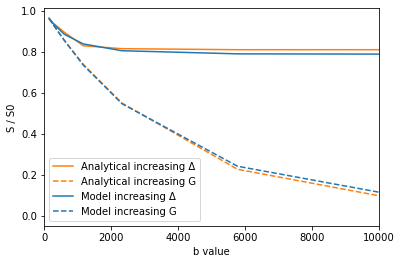

In [28]:
plt.plot(bs,rD, label="Analytical increasing Δ", color = "#ff7f0e")
plt.plot(bs,rG, label="Analytical increasing G", color = "#ff7f0e", linestyle="dashed")
plt.plot(bs,mrD, label="Model increasing Δ", color = "#1f77b4")
plt.plot(bs,mrG, label="Model increasing G", color = "#1f77b4", linestyle="dashed")
plt.xlim(0,10000)
#plt.title("Showing collision and effect on diffusion works by changing composition of b values")
plt.xlabel("b value")
plt.ylabel("S / S0")
plt.legend()

In [3]:
# R

vals = np.array([0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035, 0.004 , 0.0045,
       0.005 , 0.01]) *1000

R = [0.5654048639307497,
0.575182761885787,
0.5679314407632687,
0.563532906501439,
0.56533258527165,
0.5688234932847819,
0.5639660573094892,
0.5610889806256588,
0.5511745425049384,
0.4518994362681123
]

AR = [0.5673947368494777,
 0.5673183572369455,
 0.5671147994004153,
 0.5666915171700547,
 0.5659355436522632,
 0.5647183281234853,
 0.5629021637081453,
 0.560348902751626,
 0.5569313623627301,
 0.47347823746742546]


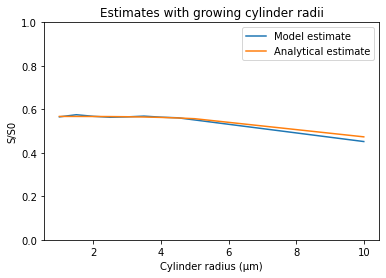

In [5]:
plt.plot(vals,R, label="Model estimate" )
plt.plot(vals,AR, label="Analytical estimate")
plt.ylim(0,1)
plt.title("Estimates with growing cylinder radii")
plt.ylabel("S/S0")
plt.xlabel("Cylinder radius (µm)")
plt.legend()

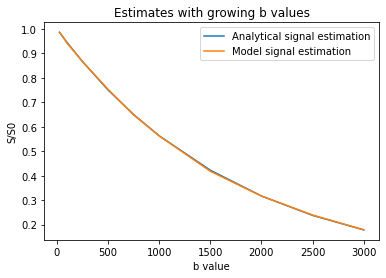

In [49]:
AR = [0.9859187646646992,
      0.97345362121322,
      0.941241546231532,
0.8668289513938454,
0.7529207747060817,
0.648300368484001,
0.5625455939532334,
0.4180317010420987,
0.3166045815310845,
0.23907681182244023,
0.17890563878494192]

R = [0.98573647, 0.97167638, 0.94415499, 0.86618016, 0.75026806,
       0.64986731, 0.56290216, 0.42232752, 0.31685885, 0.23772907,
       0.17836053]

bs = [25,50,100,250,500,750,1000,1500,2000,2500,3000]

    
#plt.plot(R)
#plt.plot(AR)
plt.title("Estimates with growing b values")
plt.ylabel("S/S0")
plt.xlabel("b value")
plt.plot(bs,R, label="Analytical signal estimation")
plt.plot(bs,AR, label="Model signal estimation")
#plt.scatter(bs,R, s=10, label="Model signal estimation")
#plt.scatter(bs,AR, s=10, label="Analytical signal estimation")
D = 1.7
R = 0.004
gradient_duration = int(10 / course_grain) # ms
delta = int(14 / course_grain)
grads = [0.018,0.057,0.08,0.099,0.114,0.140,0.161,0.180,0.198]
plt.legend()

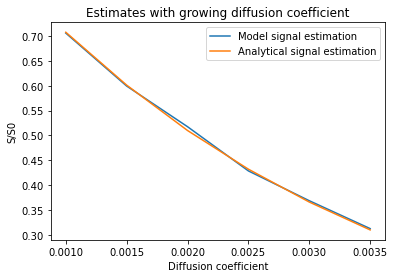

In [37]:
AR = [0.7073926990825502,
 0.601122839505985,
 0.5099062449280763,
 0.43218927922672157,
 0.3661653989169666,
 0.31015192217890225]

R = [0.7056844501885308,
0.5992759543973972,
0.5175574069120017,
0.4287037717987094,
0.36881107102211047,
0.3127921632055539]

bs = np.array([1e-09,1.5e-09,2e-09,2.5e-09,3e-09,3.5e-09]) * 1000000

    
#plt.plot(R)
#plt.plot(AR)
plt.title("Estimates with growing diffusion coefficient")
plt.ylabel("S/S0")
plt.xlabel("Diffusion coefficient")
plt.plot(bs,R, label="Model signal estimation")
plt.plot(bs,AR, label="Analytical signal estimation")
#plt.scatter(bs,R, s=10, label="Model signal estimation")
#plt.scatter(bs,AR, s=10, label="Analytical signal estimation")
#plt.ylim(0.7,1)
plt.legend()